In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix

In [15]:
# Set random seed for reproducibility
np.random.seed(42)
np.set_printoptions(suppress=True)

In [16]:
# Define the parameters for Gaussian distributions
means = [np.array([0, 0, 0]), np.array([3, 3, 3]), np.array([6, 6, 6]), np.array([9, 9, 9])]
cov = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
priors = [0.3, 0.3, 0.4]

# Number of samples to generate
n_samples = 10000
samples = np.zeros((n_samples, 3))
labels = np.zeros(n_samples)

In [17]:
# Generate samples from the Gaussian mixtures
for i in range(n_samples):
    class_label = np.random.choice([0, 1, 2], p=priors)
    if class_label == 2:                                        
        component = np.random.choice([2, 3])
        samples[i] = multivariate_normal.rvs(mean=means[component], cov=cov)
    else:
        samples[i] = multivariate_normal.rvs(mean=means[class_label], cov=cov)
    labels[i] = class_label

In [18]:
# Define the class-conditional probability density functions
class_conditional_pdfs = [
    lambda x: multivariate_normal.pdf(x, mean=means[0], cov=cov),
    lambda x: multivariate_normal.pdf(x, mean=means[1], cov=cov),
    lambda x: (multivariate_normal.pdf(x, mean=means[2], cov=cov) + multivariate_normal.pdf(x, mean=means[3], cov=cov)) / 2,
]

Part A: Minimum probability of error classification using Bayes classifier

In [19]:
p_true_model = np.zeros(n_samples)
for i in range(n_samples):
    posteriors = [priors[j] * class_conditional_pdfs[j](samples[i]) for j in range(3)]
    p_true_model[i] = np.argmax(posteriors)

# Compute confusion matrix for the Bayes classifier
cm_true_model = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        cm_true_model[i, j] = np.sum((p_true_model == i) & (labels == j))
cm_true_model /= n_samples

print(cm_true_model)

[[0.3015 0.0092 0.    ]
 [0.01   0.2779 0.0076]
 [0.     0.008  0.3858]]


In [20]:
def visualize(p, t, samples, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    markers = ['o', '^', 's']
    colors = ['g', 'g', 'g']
    labels_marker = ['Class 1 (Correct)', 'Class 1 (Incorrect)', 'Class 2 (Correct)', 'Class 2 (Incorrect)', 'Class 3 (Correct)', 'Class 3 (Incorrect)']

    for label in range(3):
        idx_correct = (labels == label) & (p == label)
        idx_incorrect = (labels == label) & (p != label)
        ax.scatter(samples[idx_correct, 0], samples[idx_correct, 1], samples[idx_correct, 2], c=colors[label], marker=markers[label], label=labels_marker[label * 2], alpha=0.6)
        ax.scatter(samples[idx_incorrect, 0], samples[idx_incorrect, 1], samples[idx_incorrect, 2], c='r', marker=markers[label], label=labels_marker[label * 2 + 1], alpha=0.6)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(t)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

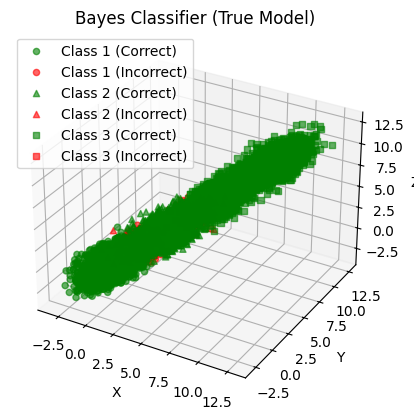

In [21]:
# Visualize results for Part A
visualize(p_true_model, 'Bayes Classifier (True Model)', samples, labels)

Part B: ERM classification with different loss matrices

In [22]:
# Define the loss matrices
l_10 = np.array([[0, 1, 10], [1, 0, 10], [1, 1, 0]])
l_100 = np.array([[0, 1, 100], [1, 0, 100], [1, 1, 0]])

In [23]:
# ERM classifier function
def erm(sample, l):
    risks = [np.sum(l[:, j] * [priors[i] * class_conditional_pdfs[i](sample) for i in range(3)]) for j in range(3)]
    return np.argmin(risks)

In [24]:
# Classify samples using ERM classifier for both loss matrices
p_10 = np.array([erm(samples[i], l_10) for i in range(n_samples)])
p_100 = np.array([erm(samples[i], l_100) for i in range(n_samples)])

In [25]:
# Compute confusion matrices for both loss matrices
cm_10 = np.zeros((3, 3))
cm_100 = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        cm_10[i, j] = np.sum((p_10 == i) & (labels == j))
        cm_100[i, j] = np.sum((p_100 == i) & (labels == j))

cm_10 /= n_samples
cm_100 /= n_samples

print("Confusion matrix for 10 times: \n", cm_10)
print("Confusion matrix for 100 times: \n", cm_100)

Confusion matrix for 10 times: 
 [[0.3015 0.0092 0.    ]
 [0.01   0.2839 0.0247]
 [0.     0.002  0.3687]]
Confusion matrix for 100 times: 
 [[0.3015 0.0092 0.    ]
 [0.01   0.2856 0.0634]
 [0.     0.0003 0.33  ]]


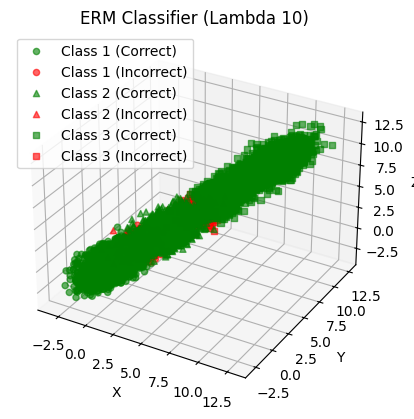

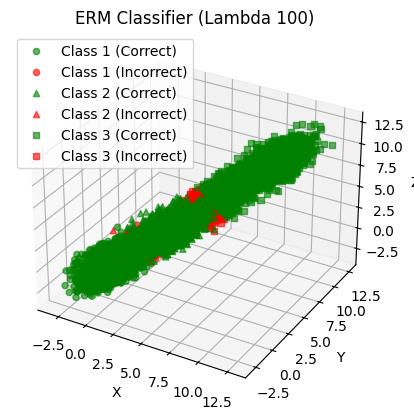

In [26]:
# Visualize results for Part B
visualize(p_10, 'ERM Classifier (Lambda 10)', samples, labels)
visualize(p_100, 'ERM Classifier (Lambda 100)', samples, labels)
